안녕하세요.<br>
"재무제표 분석을 통한 투자 성향 맞춤형 글로벌 투자 가이드"를 주제로 대회에 참여한 팀Omin_입니다.<br><br>

**제안배경**<br>
해외 주식 시장에 뛰어들고 싶지만, 방법을 몰라 망설이는 분들을 위해,
저희 팀은 국내외 주식을 직관적인 기준을 기반으로 관계를 도출하고, 투자자의 투자 성향을 기반으로 맞춤형 종목 투자를 추천하고자 합니다.


In [92]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [1]:
!pip install gym
!pip install stable-baselines3 --quiet
!pip install 'shimmy>=0.2.1' --quiet
!pip install optuna --quiet
!pip install tslearn --quiet
!pip install pykrx --quiet
!pip install finance-datareader --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.8/369.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.1/247.1 kB 33.6 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt # 맷플롯립 import 하기
plt.rcParams['font.family'] = 'NanumBarunGothic' # 나눔바른고딕 적용하기
plt.rc("axes", unicode_minus = False)

In [3]:
import pandas as pd
import chardet
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

import FinanceDataReader as fdr
from pykrx import stock

import gym
from gym import spaces
import optuna
from stable_baselines3 import DDPG
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

from pykrx import stock
import yfinance as yf

import cv2
from google.colab.patches import cv2_imshow
import warnings

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


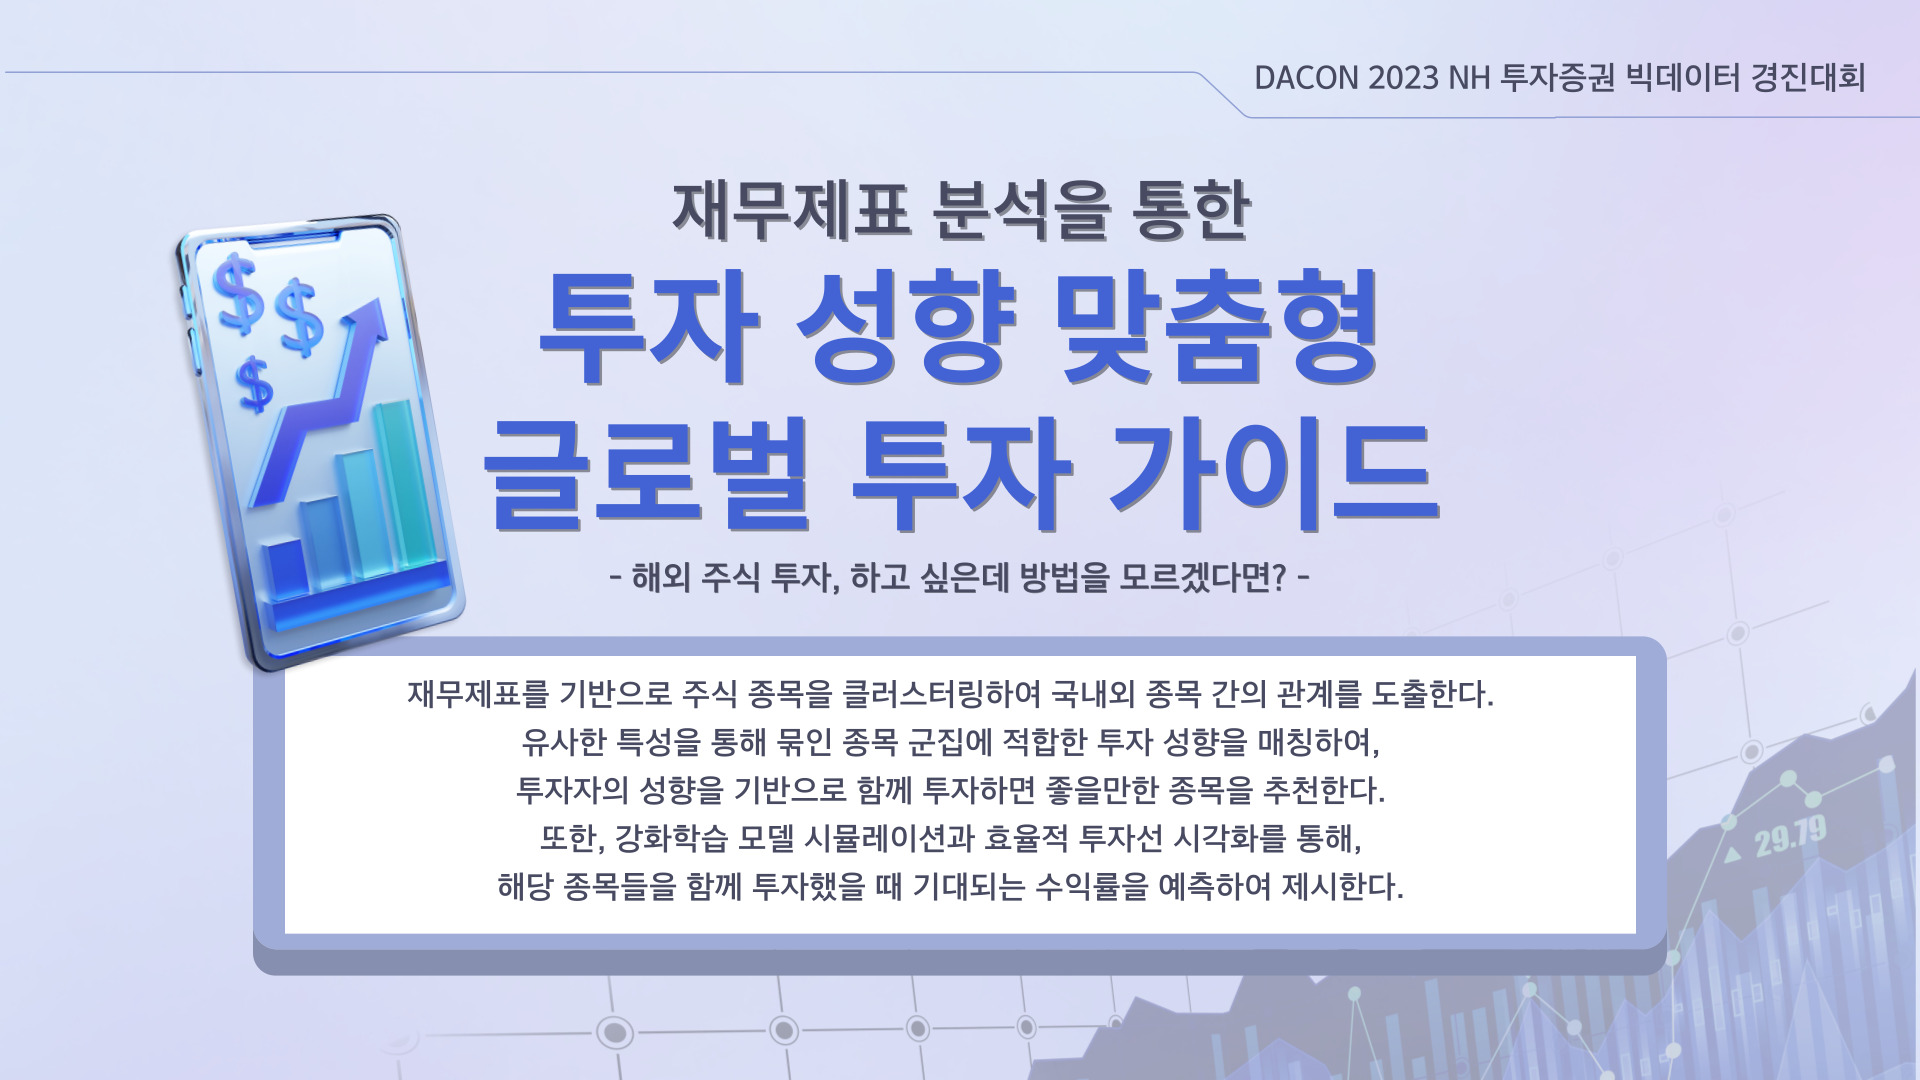

In [ ]:
img_path = '/content/drive/MyDrive/DACON_NH/001.jpg'
img1 = cv2.imread(img_path)
cv2_imshow(img1)

## 1. 데이터 로드 및 전처리

In [5]:
df_korea = pd.read_excel('한국.xlsx')
df_usa = pd.read_excel('미국.xlsx')

In [6]:
df_kospi = fdr.StockListing('KOSPI')
df_snp500 = fdr.StockListing('S&P500')
df_nasdaq = fdr.StockListing('NASDAQ')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 4128/4128 [00:26<00:00, 154.03it/s]


In [7]:
df_korea['Code'] = [i[1:] for i in df_korea['Code']]
df_korea.index = range(len(df_korea))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# 한국 재무제표 종목 - KOSPI 상장 종목 매칭
kospi_list = list(df_kospi['Code'])
lst = []
for i in range(len(df_korea['Code'])):
  if df_korea.iloc[i, 0] not in kospi_list:
    lst.append(i)

df_korea.drop(lst, axis=0, inplace=True)

df_korea.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Code,Name,결산월,매출총이익률,매출총이익률.1,매출총이익률.2,매출총이익률.3,매출총이익률.4,매출총이익률.5,매출총이익률.6,...,매입채무회전율.44,매입채무회전율.45,매입채무회전율.46,매입채무회전율.47,매입채무회전율.48,매입채무회전율.49,매입채무회전율.50,매입채무회전율.51,매입채무회전율.52,매입채무회전율.53
0,000020,동화약품,12.0,44.59,45.47,42.68,41.83,48.63,44.51,46.65,...,3.60363,3.34723,3.25965,4.29386,3.99632,3.30524,3.18738,3.56440,3.74977,3.03929
1,000040,KR모터스,12.0,12.97,14.47,14.31,10.31,14.49,15.87,11.28,...,1.60130,NaN,NaN,2.01548,1.53346,1.59770,0.75911,0.70954,1.03861,NaN
2,000050,경방,12.0,14.84,17.62,15.74,21.96,28.62,9.90,-6.68,...,4.58551,5.41150,5.59464,5.36034,4.57665,5.78914,5.32959,4.47834,4.22595,4.95175
3,000070,삼양홀딩스,12.0,10.79,10.14,14.19,13.30,13.25,11.39,10.78,...,3.37890,3.60337,3.82260,3.56767,3.42499,3.60836,4.15214,4.43955,4.40181,4.91346
4,000080,하이트진로,12.0,42.97,43.12,40.33,39.98,41.06,40.47,38.99,...,3.89724,3.70925,3.97850,4.04073,3.91160,4.09372,3.94643,3.65441,3.62151,3.70626


In [9]:
df_korea.drop_duplicates(subset='Code', keep='first', inplace=True) # 중복 제거
df_korea

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Code,Name,결산월,매출총이익률,매출총이익률.1,매출총이익률.2,매출총이익률.3,매출총이익률.4,매출총이익률.5,매출총이익률.6,...,매입채무회전율.44,매입채무회전율.45,매입채무회전율.46,매입채무회전율.47,매입채무회전율.48,매입채무회전율.49,매입채무회전율.50,매입채무회전율.51,매입채무회전율.52,매입채무회전율.53
0,000020,동화약품,12.0,44.59,45.47,42.68,41.83,48.63,44.51,46.65,...,3.60363,3.34723,3.25965,4.29386,3.99632,3.30524,3.18738,3.56440,3.74977,3.03929
1,000040,KR모터스,12.0,12.97,14.47,14.31,10.31,14.49,15.87,11.28,...,1.60130,NaN,NaN,2.01548,1.53346,1.59770,0.75911,0.70954,1.03861,NaN
2,000050,경방,12.0,14.84,17.62,15.74,21.96,28.62,9.90,-6.68,...,4.58551,5.41150,5.59464,5.36034,4.57665,5.78914,5.32959,4.47834,4.22595,4.95175
3,000070,삼양홀딩스,12.0,10.79,10.14,14.19,13.30,13.25,11.39,10.78,...,3.37890,3.60337,3.82260,3.56767,3.42499,3.60836,4.15214,4.43955,4.40181,4.91346
4,000080,하이트진로,12.0,42.97,43.12,40.33,39.98,41.06,40.47,38.99,...,3.89724,3.70925,3.97850,4.04073,3.91160,4.09372,3.94643,3.65441,3.62151,3.70626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1943,213500,한솔제지,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.38072,2.90456,2.86522,3.41384,3.10590,3.28368,3.04649,3.49656,3.46166,3.43926
1951,214320,이노션,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.31843,1.98322,1.82311,1.94493,1.26186,1.57921,1.64327,1.70746,1.53444,1.87039
1952,214330,금호에이치티,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.12418,2.13331,2.13726,2.31262,2.33315,2.10863,2.46224,2.45153,2.08568,2.18204
1954,214390,경보제약,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.15937,3.74457,3.81039,3.27486,2.93733,3.00585,2.70670,3.46189,2.99561,3.13125


In [10]:
len(df_korea['Code'].unique())
df_usa.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Code,Name,결산월,매출총이익률,매출총이익률.1,매출총이익률.2,매출총이익률.3,매출총이익률.4,매출총이익률.5,매출총이익률.6,...,매입채무회전율.44,매입채무회전율.45,매입채무회전율.46,매입채무회전율.47,매입채무회전율.48,매입채무회전율.49,매입채무회전율.50,매입채무회전율.51,매입채무회전율.52,매입채무회전율.53
0,AAPL-US,Apple,9.0,41.67,39.08,36.93,38.51,41.42,41.73,40.26,...,1.72322,2.02230,1.75178,1.91977,1.53141,1.64235,1.60319,1.92004,1.88049,1.82493
1,MSFT-US,Microsoft,6.0,81.00,80.24,80.62,75.78,76.28,78.65,78.26,...,3.18585,3.23024,3.02164,3.43183,3.14405,2.95653,2.81513,3.30050,3.44806,3.36461
2,AMZN-US,Amazon Com,12.0,22.86,24.51,23.47,20.32,22.82,24.09,23.46,...,1.59042,1.73948,1.61106,1.83048,1.58200,1.73481,1.82907,2.02503,1.73859,1.97060
3,NVDA-US,NVIDIA,1.0,44.65,45.56,16.56,46.46,48.10,50.36,51.68,...,4.35422,4.68045,4.83432,4.52709,4.43458,4.38287,3.03348,3.03221,4.50894,6.16281
4,GOOGL-US,Alphabet Class A,12.0,63.81,63.83,64.97,65.10,65.76,64.86,65.25,...,10.64755,13.01504,13.96782,14.14156,14.35891,17.76546,12.89993,13.30557,14.98862,15.71107


In [11]:
df_usa['Code'] = [i[:-3] for i in df_usa['Code']]
df_usa['Code'] = df_usa['Code'].str.strip()
df_usa.index = range(len(df_usa))
df_usa

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Code,Name,결산월,매출총이익률,매출총이익률.1,매출총이익률.2,매출총이익률.3,매출총이익률.4,매출총이익률.5,매출총이익률.6,...,매입채무회전율.44,매입채무회전율.45,매입채무회전율.46,매입채무회전율.47,매입채무회전율.48,매입채무회전율.49,매입채무회전율.50,매입채무회전율.51,매입채무회전율.52,매입채무회전율.53
0,AAPL,Apple,9.0,41.67,39.08,36.93,38.51,41.42,41.73,40.26,...,1.72322,2.02230,1.75178,1.91977,1.53141,1.64235,1.60319,1.92004,1.88049,1.82493
1,MSFT,Microsoft,6.0,81.00,80.24,80.62,75.78,76.28,78.65,78.26,...,3.18585,3.23024,3.02164,3.43183,3.14405,2.95653,2.81513,3.30050,3.44806,3.36461
2,AMZN,Amazon Com,12.0,22.86,24.51,23.47,20.32,22.82,24.09,23.46,...,1.59042,1.73948,1.61106,1.83048,1.58200,1.73481,1.82907,2.02503,1.73859,1.97060
3,NVDA,NVIDIA,1.0,44.65,45.56,16.56,46.46,48.10,50.36,51.68,...,4.35422,4.68045,4.83432,4.52709,4.43458,4.38287,3.03348,3.03221,4.50894,6.16281
4,GOOGL,Alphabet Class A,12.0,63.81,63.83,64.97,65.10,65.76,64.86,65.25,...,10.64755,13.01504,13.96782,14.14156,14.35891,17.76546,12.89993,13.30557,14.98862,15.71107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,LSXMA,Liberty Media Liberty SiriusXM Series A,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,SITC,SITE Centers,12.0,69.49,69.53,69.18,73.61,68.76,68.59,68.97,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,CPE,Callon Petroleum,12.0,80.12,81.31,78.88,80.75,80.18,85.61,82.18,...,3.99646,5.13831,6.60051,6.10619,5.42511,5.13653,4.26447,3.88972,2.86908,2.98533
1998,FIBK,First Interstate BancSystem,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# 미국 재무제표 종목 - SnP500, NASDAQ 상장 종목 매칭
df_snp500['Symbol'] = df_snp500['Symbol'].str.strip()
df_nasdaq['Symbol'] = df_nasdaq['Symbol'].str.strip()

usa_list = list(df_usa.index)
snp_list = list(df_snp500.index)
nasdaq_list = list(df_nasdaq.index)

fdr_list = snp_list + nasdaq_list
fdr_list = set(fdr_list)

lst = []
for i in usa_list:
    if i in usa_list:
        lst.append(i)

len(lst)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2000

In [13]:
df_usa = df_usa.loc[lst,:]
df_usa

,Code,Name,결산월,매출총이익률,매출총이익률.1,매출총이익률.2,매출총이익률.3,매출총이익률.4,매출총이익률.5,매출총이익률.6,...,매입채무회전율.44,매입채무회전율.45,매입채무회전율.46,매입채무회전율.47,매입채무회전율.48,매입채무회전율.49,매입채무회전율.50,매입채무회전율.51,매입채무회전율.52,매입채무회전율.53
0,AAPL,Apple,9.0,41.67,39.08,36.93,38.51,41.42,41.73,40.26,...,1.72322,2.02230,1.75178,1.91977,1.53141,1.64235,1.60319,1.92004,1.88049,1.82493
1,MSFT,Microsoft,6.0,81.00,80.24,80.62,75.78,76.28,78.65,78.26,...,3.18585,3.23024,3.02164,3.43183,3.14405,2.95653,2.81513,3.30050,3.44806,3.36461
2,AMZN,Amazon Com,12.0,22.86,24.51,23.47,20.32,22.82,24.09,23.46,...,1.59042,1.73948,1.61106,1.83048,1.58200,1.73481,1.82907,2.02503,1.73859,1.97060
3,NVDA,NVIDIA,1.0,44.65,45.56,16.56,46.46,48.10,50.36,51.68,...,4.35422,4.68045,4.83432,4.52709,4.43458,4.38287,3.03348,3.03221,4.50894,6.16281
4,GOOGL,Alphabet Class A,12.0,63.81,63.83,64.97,65.10,65.76,64.86,65.25,...,10.64755,13.01504,13.96782,14.14156,14.35891,17.76546,12.89993,13.30557,14.98862,15.71107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,LSXMA,Liberty Media Liberty SiriusXM Series A,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,SITC,SITE Centers,12.0,69.49,69.53,69.18,73.61,68.76,68.59,68.97,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,CPE,Callon Petroleum,12.0,80.12,81.31,78.88,80.75,80.18,85.61,82.18,...,3.99646,5.13831,6.60051,6.10619,5.42511,5.13653,4.26447,3.88972,2.86908,2.98533
1998,FIBK,First Interstate BancSystem,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
len(df_usa['Code'].unique())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2000

In [15]:
print(df_korea.shape, df_usa.shape)

(736, 1569) (2000, 1515)


In [16]:
korea_columns = set(df_korea.columns)
usa_columns = set(df_usa.columns)

if korea_columns == usa_columns:
    print("두 데이터프레임의 열이 동일합니다.")
else:
    print("두 데이터프레임의 열이 다릅니다.")

    # 어떤 열이 다른지 확인
    diff_columns_korea = korea_columns - usa_columns
    diff_columns_usa = usa_columns - korea_columns

    print("한국 데이터프레임에만 있는 열:", diff_columns_korea) # 비유동부채비율, EBITDA/순이자비용
    print("미국 데이터프레임에만 있는 열:", diff_columns_usa) # EBITDA/이자비용

두 데이터프레임의 열이 다릅니다.
한국 데이터프레임에만 있는 열: {'비유동부채비율.29', 'EBITDA/순이자비용', '비유동부채비율.11', 'EBITDA/순이자비용.24', 'EBITDA/순이자비용.35', 'EBITDA/순이자비용.6', 'EBITDA/순이자비용.20', 'EBITDA/순이자비용.15', '비유동부채비율.22', '비유동부채비율.17', 'EBITDA/순이자비용.22', 'EBITDA/순이자비용.21', '비유동부채비율.51', 'EBITDA/순이자비용.31', '비유동부채비율.47', 'EBITDA/순이자비용.43', '비유동부채비율.18', 'EBITDA/순이자비용.13', 'EBITDA/순이자비용.3', '비유동부채비율.12', '비유동부채비율.32', 'EBITDA/순이자비용.12', 'EBITDA/순이자비용.51', 'EBITDA/순이자비용.45', 'EBITDA/순이자비용.52', 'EBITDA/순이자비용.27', '비유동부채비율.19', '비유동부채비율.41', 'EBITDA/순이자비용.36', '비유동부채비율.21', '비유동부채비율', '비유동부채비율.23', '비유동부채비율.16', '비유동부채비율.42', 'EBITDA/순이자비용.16', '비유동부채비율.3', 'EBITDA/순이자비용.38', 'EBITDA/순이자비용.34', '비유동부채비율.33', '비유동부채비율.7', '비유동부채비율.52', '비유동부채비율.50', '비유동부채비율.49', 'EBITDA/순이자비용.53', 'EBITDA/순이자비용.1', '비유동부채비율.37', '비유동부채비율.8', '비유동부채비율.53', 'EBITDA/순이자비용.48', 'EBITDA/순이자비용.26', 'EBITDA/순이자비용.4', '비유동부채비율.20', '비유동부채비율.13', 'EBITDA/순이자비용.11', 'EBITDA/순이자비용.47', '비유동부채비율.24', '비유동부채비율.26', '비유동부채비율.44', '비유동부채비율.35', 'EBITDA/순

In [17]:
# 미국-한국 union
columns_to_drop_korea = [col for col in df_korea.columns if '비유동부채비율' in col or 'EBITDA/순이자비용' in col]
df_korea = df_korea.drop(columns=columns_to_drop_korea)

columns_to_drop_usa = [col for col in df_usa.columns if 'EBITDA/이자비용' in col]
df_usa = df_usa.drop(columns=columns_to_drop_usa)

# 두 데이터프레임을 union (concatenate) 합치기
result_df = pd.concat([df_korea, df_usa], ignore_index=True)

result_df.shape

(2736, 1461)

In [18]:
result_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Code,Name,결산월,매출총이익률,매출총이익률.1,매출총이익률.2,매출총이익률.3,매출총이익률.4,매출총이익률.5,매출총이익률.6,...,매입채무회전율.44,매입채무회전율.45,매입채무회전율.46,매입채무회전율.47,매입채무회전율.48,매입채무회전율.49,매입채무회전율.50,매입채무회전율.51,매입채무회전율.52,매입채무회전율.53
0,000020,동화약품,12.0,44.59,45.47,42.68,41.83,48.63,44.51,46.65,...,3.60363,3.34723,3.25965,4.29386,3.99632,3.30524,3.18738,3.56440,3.74977,3.03929
1,000040,KR모터스,12.0,12.97,14.47,14.31,10.31,14.49,15.87,11.28,...,1.60130,NaN,NaN,2.01548,1.53346,1.59770,0.75911,0.70954,1.03861,NaN
2,000050,경방,12.0,14.84,17.62,15.74,21.96,28.62,9.90,-6.68,...,4.58551,5.41150,5.59464,5.36034,4.57665,5.78914,5.32959,4.47834,4.22595,4.95175
3,000070,삼양홀딩스,12.0,10.79,10.14,14.19,13.30,13.25,11.39,10.78,...,3.37890,3.60337,3.82260,3.56767,3.42499,3.60836,4.15214,4.43955,4.40181,4.91346
4,000080,하이트진로,12.0,42.97,43.12,40.33,39.98,41.06,40.47,38.99,...,3.89724,3.70925,3.97850,4.04073,3.91160,4.09372,3.94643,3.65441,3.62151,3.70626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,LSXMA,Liberty Media Liberty SiriusXM Series A,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2732,SITC,SITE Centers,12.0,69.49,69.53,69.18,73.61,68.76,68.59,68.97,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2733,CPE,Callon Petroleum,12.0,80.12,81.31,78.88,80.75,80.18,85.61,82.18,...,3.99646,5.13831,6.60051,6.10619,5.42511,5.13653,4.26447,3.88972,2.86908,2.98533
2734,FIBK,First Interstate BancSystem,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
len(result_df['Code'].unique())
# 미국 2000개, 한국 736개, 총 2736개 종목 존재

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2736

In [20]:
def create_melted_df(df, keyword):
    filtered = ['Code', 'Name'] + [col for col in df.columns if keyword in col]
    df1 = df[filtered]

    # 컬럼명을 날짜 형태로 변경
    selected_cols = df1.columns[df1.columns.str.contains(keyword)]
    df1 = df1.copy()

    start_date = pd.to_datetime('2010-01-01')
    date_columns = [start_date + pd.DateOffset(months=3 * i) for i in range(len(selected_cols))]
    date_column_mapping = dict(zip(selected_cols, date_columns))

    df1.rename(columns=date_column_mapping, inplace=True)

    date_column_mapping = {col: col.strftime('%Y-%m-%d') if col in date_columns else col for col in df1.columns}
    df1.rename(columns=date_column_mapping, inplace=True)

    # 'Code'와 'Name'을 기준으로 데이터를 재구성
    melted_df = pd.melt(df1, id_vars=['Code', 'Name'], var_name='시점', value_name=keyword)

    # '시점' 컬럼을 날짜 형식으로 변환
    melted_df['시점'] = pd.to_datetime(melted_df['시점'], errors='coerce')

    return melted_df

In [21]:
# 키워드 리스트 정의 (26개)
keywords = ['영업이익률', '세전계속사업이익률', '순이익률', '총포괄이익률', 'EBITDA마진율',
            'ROE', 'ROA', 'ROIC', '매출원가율', '총자산영업이익률',
            '자기자본영업이익률', '자본금영업이익률', '부채비율', '유동비율', '당좌비율',
            '유동부채비율', '자기자본비율', '이자보상배율', '순이자보상배율', '비유동비율',
            '차입금비율', '비유동적합률', '총자산회전율', '매출채권회전율', '재고자산회전율',
            '매입채무회전율']

# 키워드별로 데이터프레임 생성
melted_dfs = [create_melted_df(result_df, keyword) for keyword in keywords]

In [22]:
melted_dfs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[          Code                                     Name         시점     영업이익률
 0       000020                                     동화약품 2010-01-01      5.83
 1       000040                                    KR모터스 2010-01-01      4.02
 2       000050                                       경방 2010-01-01     12.09
 3       000070                                    삼양홀딩스 2010-01-01      0.63
 4       000080                                    하이트진로 2010-01-01     18.87
 ...        ...                                      ...        ...       ...
 590971   LSXMA  Liberty Media Liberty SiriusXM Series A 2063-10-01       NaN
 590972    SITC                             SITE Centers 2063-10-01    105.77
 590973     CPE                         Callon Petroleum 2063-10-01 -36073.85
 590974    FIBK              First Interstate BancSystem 2063-10-01       NaN
 590975     KRE            SPDR S&P Regional Banking ETF 2063-10-01       NaN
 
 [590976 rows x 4 columns],
           Code                   

In [23]:
df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15, df16, df17, df18, df19, df20, df21, df22, df23, df24, df25, df26 = melted_dfs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
# 행 수 147,774
df1_len = len(df1) // 4   # 영업이익률
df13_len = len(df13) // 2 # 부채비율
df14_len = len(df14) // 2 # 유동비율
df18_len = len(df18) // 2 # 이자보상배율

df1 = df1.iloc[:df1_len]
df13 = df13.iloc[:df13_len]
df14 = df14.iloc[:df14_len]
df18 = df18.iloc[:df18_len]

print(len(df1), ' ', len(df13), ' ', len(df14), ' ', len(df18))

147744   147744   147744   147744


In [25]:
# 6개의 데이터프레임을 melted_dfs 리스트에 저장한 후 merge
melted_dfs = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10,
              df11, df12, df13, df14, df15, df16, df17, df18, df19, df20,
              df21, df22, df23, df24, df25, df26]

# 초기 조인 대상 데이터프레임을 melted_dfs[0]으로 설정
merged_df = melted_dfs[0]

# 나머지 데이터프레임을 순회하면서 조인
for df in melted_dfs[1:]:
    merged_df = pd.merge(merged_df, df, on=['Code', 'Name', '시점'], how='inner')

# 최종 데이터프레임 확인
merged_df

,Code,Name,시점,영업이익률,세전계속사업이익률,순이익률,총포괄이익률,EBITDA마진율,ROE,ROA,...,자기자본비율,이자보상배율,순이자보상배율,비유동비율,차입금비율,비유동적합률,총자산회전율,매출채권회전율,재고자산회전율,매입채무회전율
0,000020,동화약품,2010-01-01,5.83,4.32,3.83,0.0,13.62,0.92,0.61,...,66.15,5.55,9.59,101.67,14.96,97.29,0.16022,1.06356,1.33937,3.17142
1,000040,KR모터스,2010-01-01,4.02,0.37,0.37,0.0,4.89,0.19,0.08,...,43.93,2.62,3.02,107.47,33.41,85.98,0.22686,0.71118,2.07945,0.99900
2,000050,경방,2010-01-01,12.09,9.85,8.30,0.0,28.55,0.63,0.33,...,51.90,1.25,1.33,173.68,50.68,101.18,0.03968,2.13691,1.75540,20.07550
3,000070,삼양홀딩스,2010-01-01,0.63,9.21,7.70,0.0,11.00,3.65,2.16,...,58.84,0.90,186.40,103.05,38.71,86.11,0.28052,2.46208,3.08711,3.86428
4,000080,하이트진로,2010-01-01,18.87,20.98,17.31,0.0,26.76,4.39,2.20,...,46.98,8.57,11.69,169.30,51.19,127.24,0.12716,2.95237,5.60845,2.97990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147739,LSXMA,Liberty Media Liberty SiriusXM Series A,2023-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147740,SITC,SITE Centers,2023-04-01,16.41,4.14,3.88,NaN,58.90,0.26,0.13,...,49.86,1.08,NaN,200.57,NaN,100.00,0.03405,2.27921,NaN,NaN
147741,CPE,Callon Petroleum,2023-04-01,-39.62,-46.97,-19.19,NaN,55.50,-3.00,-1.63,...,53.96,-4.72,NaN,161.96,NaN,97.50,0.08508,3.00032,NaN,2.98533
147742,FIBK,First Interstate BancSystem,2023-04-01,NaN,33.11,25.52,NaN,NaN,2.13,0.21,...,10.08,NaN,NaN,NaN,NaN,NaN,0.00838,NaN,NaN,NaN


In [26]:
result = merged_df.copy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
# 날짜형식 변환
result['시점'] = pd.to_datetime(result['시점'], format='%Y-%m-%d')
result['시점']

0        2010-01-01
1        2010-01-01
2        2010-01-01
3        2010-01-01
4        2010-01-01
            ...    
147739   2023-04-01
147740   2023-04-01
147741   2023-04-01
147742   2023-04-01
147743   2023-04-01
Name: 시점, Length: 147744, dtype: datetime64[ns]

In [28]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147744 entries, 0 to 147743
Data columns (total 29 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Code       147744 non-null  object        
 1   Name       147744 non-null  object        
 2   시점         147744 non-null  datetime64[ns]
 3   영업이익률      107316 non-null  float64       
 4   세전계속사업이익률  111843 non-null  float64       
 5   순이익률       111693 non-null  float64       
 6   총포괄이익률     37353 non-null   float64       
 7   EBITDA마진율  102059 non-null  float64       
 8   ROE        106207 non-null  float64       
 9   ROA        109211 non-null  float64       
 10  ROIC       35166 non-null   float64       
 11  매출원가율      104346 non-null  float64       
 12  총자산영업이익률   104842 non-null  float64       
 13  자기자본영업이익률  104833 non-null  float64       
 14  자본금영업이익률   101236 non-null  float64       
 15  부채비율       111660 non-null  float64       
 16  유동비율       94476 non

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
result.isna().sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Code              0
Name              0
시점                0
영업이익률         40428
세전계속사업이익률     35901
순이익률          36051
총포괄이익률       110391
EBITDA마진율     45685
ROE           41537
ROA           38533
ROIC         112578
매출원가율         43398
총자산영업이익률      42902
자기자본영업이익률     42911
자본금영업이익률      46508
부채비율          36084
유동비율          53268
당좌비율          53363
유동부채비율        53298
자기자본비율        35941
이자보상배율        65315
순이자보상배율      114479
비유동비율         45539
차입금비율        109488
비유동적합률        45459
총자산회전율        36799
매출채권회전율       48433
재고자산회전율       66704
매입채무회전율       58201
dtype: int64

In [30]:
# 최초 nan 값 발생 시점 이전은 0으로 대체
# Term을 기준으로 그룹화하고, 각 그룹에서 처음 nan 값이 시작된 시점을 파악하여 그 시점 이전의 nan 값을 0으로 대체
result['시점'] = result.groupby('Code')['시점'].transform(lambda x: x.ffill().bfill())
result = result.fillna(0)

result

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Code,Name,시점,영업이익률,세전계속사업이익률,순이익률,총포괄이익률,EBITDA마진율,ROE,ROA,...,자기자본비율,이자보상배율,순이자보상배율,비유동비율,차입금비율,비유동적합률,총자산회전율,매출채권회전율,재고자산회전율,매입채무회전율
0,000020,동화약품,2010-01-01,5.83,4.32,3.83,0.0,13.62,0.92,0.61,...,66.15,5.55,9.59,101.67,14.96,97.29,0.16022,1.06356,1.33937,3.17142
1,000040,KR모터스,2010-01-01,4.02,0.37,0.37,0.0,4.89,0.19,0.08,...,43.93,2.62,3.02,107.47,33.41,85.98,0.22686,0.71118,2.07945,0.99900
2,000050,경방,2010-01-01,12.09,9.85,8.30,0.0,28.55,0.63,0.33,...,51.90,1.25,1.33,173.68,50.68,101.18,0.03968,2.13691,1.75540,20.07550
3,000070,삼양홀딩스,2010-01-01,0.63,9.21,7.70,0.0,11.00,3.65,2.16,...,58.84,0.90,186.40,103.05,38.71,86.11,0.28052,2.46208,3.08711,3.86428
4,000080,하이트진로,2010-01-01,18.87,20.98,17.31,0.0,26.76,4.39,2.20,...,46.98,8.57,11.69,169.30,51.19,127.24,0.12716,2.95237,5.60845,2.97990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147739,LSXMA,Liberty Media Liberty SiriusXM Series A,2023-04-01,0.00,0.00,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00000,0.00000,0.00000,0.00000
147740,SITC,SITE Centers,2023-04-01,16.41,4.14,3.88,0.0,58.90,0.26,0.13,...,49.86,1.08,0.00,200.57,0.00,100.00,0.03405,2.27921,0.00000,0.00000
147741,CPE,Callon Petroleum,2023-04-01,-39.62,-46.97,-19.19,0.0,55.50,-3.00,-1.63,...,53.96,-4.72,0.00,161.96,0.00,97.50,0.08508,3.00032,0.00000,2.98533
147742,FIBK,First Interstate BancSystem,2023-04-01,0.00,33.11,25.52,0.0,0.00,2.13,0.21,...,10.08,0.00,0.00,0.00,0.00,0.00,0.00838,0.00000,0.00000,0.00000


In [31]:
result.to_csv('한국미국종목별_재무제표26개총합.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
import pandas as pd
df = pd.read_csv('/content/한국미국종목별_재무제표26개총합.csv')
df

,Code,Name,시점,영업이익률,세전계속사업이익률,순이익률,총포괄이익률,EBITDA마진율,ROE,ROA,...,자기자본비율,이자보상배율,순이자보상배율,비유동비율,차입금비율,비유동적합률,총자산회전율,매출채권회전율,재고자산회전율,매입채무회전율
0,000020,동화약품,2010-01-01,5.83,4.32,3.83,0.0,13.62,0.92,0.61,...,66.15,5.55,9.59,101.67,14.96,97.29,0.16022,1.06356,1.33937,3.17142
1,000040,KR모터스,2010-01-01,4.02,0.37,0.37,0.0,4.89,0.19,0.08,...,43.93,2.62,3.02,107.47,33.41,85.98,0.22686,0.71118,2.07945,0.99900
2,000050,경방,2010-01-01,12.09,9.85,8.30,0.0,28.55,0.63,0.33,...,51.90,1.25,1.33,173.68,50.68,101.18,0.03968,2.13691,1.75540,20.07550
3,000070,삼양홀딩스,2010-01-01,0.63,9.21,7.70,0.0,11.00,3.65,2.16,...,58.84,0.90,186.40,103.05,38.71,86.11,0.28052,2.46208,3.08711,3.86428
4,000080,하이트진로,2010-01-01,18.87,20.98,17.31,0.0,26.76,4.39,2.20,...,46.98,8.57,11.69,169.30,51.19,127.24,0.12716,2.95237,5.60845,2.97990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147739,LSXMA,Liberty Media Liberty SiriusXM Series A,2023-04-01,0.00,0.00,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00000,0.00000,0.00000,0.00000
147740,SITC,SITE Centers,2023-04-01,16.41,4.14,3.88,0.0,58.90,0.26,0.13,...,49.86,1.08,0.00,200.57,0.00,100.00,0.03405,2.27921,0.00000,0.00000
147741,CPE,Callon Petroleum,2023-04-01,-39.62,-46.97,-19.19,0.0,55.50,-3.00,-1.63,...,53.96,-4.72,0.00,161.96,0.00,97.50,0.08508,3.00032,0.00000,2.98533
147742,FIBK,First Interstate BancSystem,2023-04-01,0.00,33.11,25.52,0.0,0.00,2.13,0.21,...,10.08,0.00,0.00,0.00,0.00,0.00,0.00838,0.00000,0.00000,0.00000


In [43]:
result_scaled = df.copy()
df.isnull().sum()

Code         0
Name         0
시점           0
영업이익률        0
세전계속사업이익률    0
순이익률         0
총포괄이익률       0
EBITDA마진율    0
ROE          0
ROA          0
ROIC         0
매출원가율        0
총자산영업이익률     0
자기자본영업이익률    0
자본금영업이익률     0
부채비율         0
유동비율         0
당좌비율         0
유동부채비율       0
자기자본비율       0
이자보상배율       0
순이자보상배율      0
비유동비율        0
차입금비율        0
비유동적합률       0
총자산회전율       0
매출채권회전율      0
재고자산회전율      0
매입채무회전율      0
dtype: int64

In [44]:
result_scaled.columns

Index(['Code', 'Name', '시점', '영업이익률', '세전계속사업이익률', '순이익률', '총포괄이익률',
       'EBITDA마진율', 'ROE', 'ROA', 'ROIC', '매출원가율', '총자산영업이익률', '자기자본영업이익률',
       '자본금영업이익률', '부채비율', '유동비율', '당좌비율', '유동부채비율', '자기자본비율', '이자보상배율',
       '순이자보상배율', '비유동비율', '차입금비율', '비유동적합률', '총자산회전율', '매출채권회전율', '재고자산회전율',
       '매입채무회전율'],
      dtype='object')

In [45]:
num_cols = ['영업이익률', '세전계속사업이익률', '순이익률',
       '총포괄이익률', 'EBITDA마진율', 'ROE', 'ROA', 'ROIC', '매출원가율', '총자산영업이익률',
       '자기자본영업이익률', '자본금영업이익률', '부채비율', '유동비율', '당좌비율', '유동부채비율', '자기자본비율',
       '이자보상배율', '순이자보상배율', '비유동비율', '차입금비율', '비유동적합률', '총자산회전율', '매출채권회전율',
       '재고자산회전율', '매입채무회전율']

## 2. Dynamic Time Warping Clustering

In [46]:
group = result_scaled.groupby('Name').mean()
group.head()

<ipython-input-46-6cc2a9d80ff3>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  group = result_scaled.groupby('Name').mean()


,영업이익률,세전계속사업이익률,순이익률,총포괄이익률,EBITDA마진율,ROE,ROA,ROIC,매출원가율,총자산영업이익률,...,자기자본비율,이자보상배율,순이자보상배율,비유동비율,차입금비율,비유동적합률,총자산회전율,매출채권회전율,재고자산회전율,매입채무회전율
Name,,,,,,,,,,,,,,,,,,,,,
10x Genomics Class A,-23.455000,-23.481667,-23.807593,0.0,-14.449259,-2.364259,-2.691852,0.0,9.727222,-2.642593,...,24.430926,-352.128704,0.0,18.122593,0.0,10.589074,0.106988,0.705477,1.860919,3.102436
3M,19.232407,18.675370,13.944074,0.0,26.684259,8.053148,3.076667,0.0,52.225000,4.264630,...,38.465185,-6.240741,0.0,182.153148,0.0,78.176667,0.215173,1.697647,1.969766,3.947888
A O Smith,13.461296,13.461296,11.055000,0.0,16.409630,5.089259,2.710370,0.0,63.030185,3.379444,...,53.187963,0.000000,0.0,94.392037,0.0,66.545926,0.245172,1.318294,2.579188,1.551296
ABM Industries,2.563889,2.214259,1.541852,0.0,4.365000,1.855926,0.770370,0.0,88.426852,1.278519,...,41.228704,8.058148,0.0,150.752963,0.0,81.270741,0.511350,1.616524,0.000000,7.899377
ACADIA Pharmaceuticals,-130972.677407,-130349.162222,-130385.580185,0.0,-130215.720556,-11.651481,-9.735926,0.0,290.742407,-9.879630,...,79.045926,-8.481481,0.0,-1.574815,0.0,5.396111,0.100633,2.028555,6.945104,7.623831


In [47]:
X = group.iloc[:, 0:].values  # 3번째 열 이후의 열이 시계열 데이터

# 데이터 전처리: 시계열 데이터 스케일링
X = TimeSeriesScalerMeanVariance().fit_transform(X)

In [48]:
# 3D 배열을 2D 배열로 변환
n_samples, n_timestamps, n_features = X.shape
X_2d = X.reshape(n_samples, -1)

# 시도할 클러스터 개수 범위
min_clusters = 2
max_clusters = 10

best_silhouette_score = -1
best_n_clusters = 0

for n_clusters in range(min_clusters, max_clusters + 1):
    model = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=0)
    y_pred = model.fit_predict(X)

    # 실루엣 점수 계산
    silhouette_avg = silhouette_score(X_2d, y_pred)

    # 가장 높은 실루엣 점수를 갖는 클러스터 개수 찾기
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_n_clusters = n_clusters

print(f"Best number of clusters: {best_n_clusters}")
print(f"Best silhouette score: {best_silhouette_score}")

Best number of clusters: 8
Best silhouette score: 0.5899650254919889


In [49]:
# 데이터 클러스터링
n_clusters = 8 # 클러스터 개수
model = TimeSeriesKMeans(n_clusters=n_clusters, verbose=True, random_state=0)
y_pred = model.fit_predict(X)

4.248 --> 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3.427 --> 3.411 --> 3.410 --> 3.410 --> 3.410 --> 


In [ ]:
# 클러스터링 결과 출력
for cluster in range(n_clusters):
    cluster_samples = np.where(y_pred == cluster)[0]
    print(f"Cluster {cluster}: {len(cluster_samples)}")

In [ ]:
# 클러스터별 데이터 포인트 수 계산
cluster_counts = Counter(y_pred)

# 결과 출력
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} data points")

In [50]:
group['Cluster'] = y_pred + 1 # 0,1,2 -> 1,2,3
group

,영업이익률,세전계속사업이익률,순이익률,총포괄이익률,EBITDA마진율,ROE,ROA,ROIC,매출원가율,총자산영업이익률,...,이자보상배율,순이자보상배율,비유동비율,차입금비율,비유동적합률,총자산회전율,매출채권회전율,재고자산회전율,매입채무회전율,Cluster
Name,,,,,,,,,,,,,,,,,,,,,
10x Genomics Class A,-23.455000,-23.481667,-23.807593,0.000000,-14.449259,-2.364259,-2.691852,0.000000,9.727222,-2.642593,...,-352.128704,0.000000,18.122593,0.000000,10.589074,0.106988,0.705477,1.860919,3.102436,4
3M,19.232407,18.675370,13.944074,0.000000,26.684259,8.053148,3.076667,0.000000,52.225000,4.264630,...,-6.240741,0.000000,182.153148,0.000000,78.176667,0.215173,1.697647,1.969766,3.947888,2
A O Smith,13.461296,13.461296,11.055000,0.000000,16.409630,5.089259,2.710370,0.000000,63.030185,3.379444,...,0.000000,0.000000,94.392037,0.000000,66.545926,0.245172,1.318294,2.579188,1.551296,5
ABM Industries,2.563889,2.214259,1.541852,0.000000,4.365000,1.855926,0.770370,0.000000,88.426852,1.278519,...,8.058148,0.000000,150.752963,0.000000,81.270741,0.511350,1.616524,0.000000,7.899377,2
ACADIA Pharmaceuticals,-130972.677407,-130349.162222,-130385.580185,0.000000,-130215.720556,-11.651481,-9.735926,0.000000,290.742407,-9.879630,...,-8.481481,0.000000,-1.574815,0.000000,5.396111,0.100633,2.028555,6.945104,7.623831,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
휴니드,-3.477407,-4.119444,-4.172778,-3.264630,2.777963,1.278148,0.633889,1.286667,85.694630,0.798519,...,22.862037,-6.376481,98.303333,39.498333,77.010370,0.163868,5.456087,0.648935,3.846756,1
휴비스,0.964815,1.146296,0.876296,0.794630,4.609074,0.864259,0.370185,0.725741,79.181111,0.431852,...,4.719630,1.500926,111.649259,47.115926,91.205556,0.302072,1.771488,1.856113,1.550852,1
휴스틸,5.950741,5.514630,3.976481,5.389444,8.215185,1.473889,1.010185,1.721481,87.110741,1.455556,...,13.103889,15.007778,80.698519,26.117963,73.693333,0.228550,1.625792,1.164105,3.357166,5


In [51]:
group.reset_index(drop=False, inplace=True)
group.head()

,Name,영업이익률,세전계속사업이익률,순이익률,총포괄이익률,EBITDA마진율,ROE,ROA,ROIC,매출원가율,...,이자보상배율,순이자보상배율,비유동비율,차입금비율,비유동적합률,총자산회전율,매출채권회전율,재고자산회전율,매입채무회전율,Cluster
0,10x Genomics Class A,-23.455000,-23.481667,-23.807593,0.0,-14.449259,-2.364259,-2.691852,0.0,9.727222,...,-352.128704,0.0,18.122593,0.0,10.589074,0.106988,0.705477,1.860919,3.102436,4
1,3M,19.232407,18.675370,13.944074,0.0,26.684259,8.053148,3.076667,0.0,52.225000,...,-6.240741,0.0,182.153148,0.0,78.176667,0.215173,1.697647,1.969766,3.947888,2
2,A O Smith,13.461296,13.461296,11.055000,0.0,16.409630,5.089259,2.710370,0.0,63.030185,...,0.000000,0.0,94.392037,0.0,66.545926,0.245172,1.318294,2.579188,1.551296,5
3,ABM Industries,2.563889,2.214259,1.541852,0.0,4.365000,1.855926,0.770370,0.0,88.426852,...,8.058148,0.0,150.752963,0.0,81.270741,0.511350,1.616524,0.000000,7.899377,2
4,ACADIA Pharmaceuticals,-130972.677407,-130349.162222,-130385.580185,0.0,-130215.720556,-11.651481,-9.735926,0.0,290.742407,...,-8.481481,0.0,-1.574815,0.0,5.396111,0.100633,2.028555,6.945104,7.623831,4


In [52]:
result_merge = result_scaled.merge(group[['Name','Cluster']], on='Name', how='left')
result = df.merge(result_merge[['Name','Cluster']], on='Name', how='left')

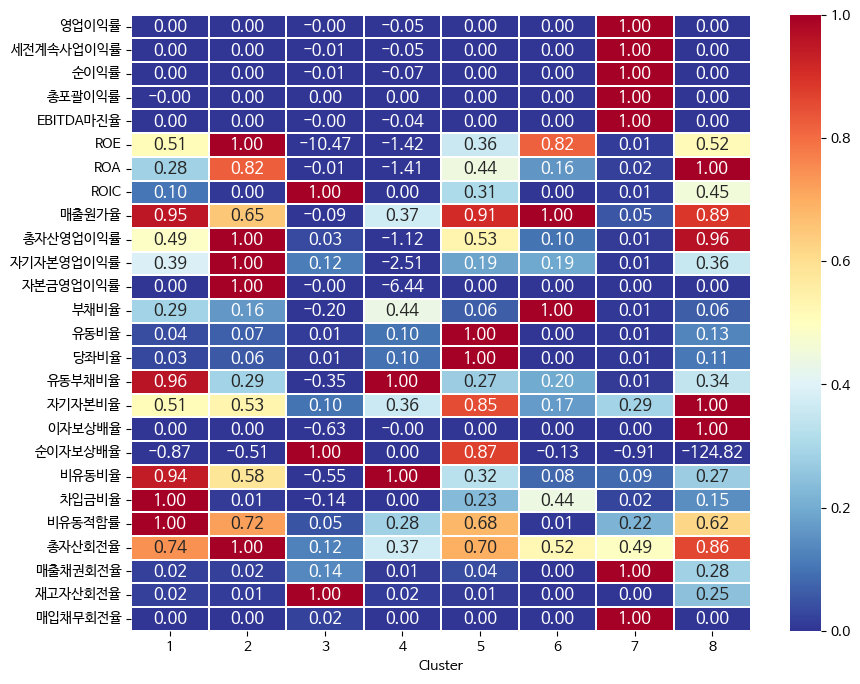

In [85]:
# 클러스터별 특징 파악
temp = result.groupby('Cluster').mean(numeric_only=True)
cluster_mean = temp.transpose()
mean_table = cluster_mean.div(cluster_mean.max(axis=1), axis=0)

plt.figure(figsize=(10,8))
annot_kws = {'fontsize':12}
vmin, vmax = 0 ,1
sns.heatmap(mean_table, annot=True, fmt='.2f',
           linewidths=0.1, annot_kws=annot_kws,
           cmap='RdYlBu_r', vmin=vmin, vmax=vmax)
plt.show()

In [86]:
mean_table

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Cluster,1,2,3,4,5,6,7,8
영업이익률,0.000084,0.000251,-0.004747,-0.046777,0.000146,0.000095,1.000000,0.000115
세전계속사업이익률,0.000040,0.000228,-0.005172,-0.050950,0.000130,0.000541,1.000000,0.000187
순이익률,0.000051,0.000241,-0.006543,-0.067027,0.000194,0.000504,1.000000,0.000365
총포괄이익률,-0.000035,0.000005,0.000054,0.000000,0.000113,0.000052,1.000000,0.000415
EBITDA마진율,0.000294,0.000465,-0.004660,-0.042657,0.000279,0.000066,1.000000,0.000268
ROE,0.514840,1.000000,-10.470476,-1.422412,0.357397,0.816424,0.012773,0.517283
ROA,0.283014,0.822078,-0.007373,-1.408400,0.443308,0.159324,0.019477,1.000000
ROIC,0.102434,0.004136,1.000000,0.000000,0.306576,0.001655,0.012537,0.453413
매출원가율,0.949667,0.648575,-0.085270,0.368664,0.908942,1.000000,0.052785,0.890055
총자산영업이익률,0.489218,1.000000,0.031731,-1.121357,0.531522,0.098609,0.010771,0.962665


In [87]:
def plot_clustered_line_chart(data, y_column):
    # 'Cluster'를 기준으로 그룹화하고 y_column 평균을 계산
    grouped_data = data.groupby(['Cluster', '시점'])[y_column].mean().reset_index()

    # 각 클러스터에 대한 라인 차트 시각화
    plt.figure(figsize=(15, 6))

    for cluster in grouped_data['Cluster'].unique():
        cluster_data = grouped_data[grouped_data['Cluster'] == cluster]
        plt.plot(cluster_data['시점'], cluster_data[y_column], '-o', label=f'Cluster {cluster}')

    plt.xlabel('시점')
    plt.ylabel(f'{y_column} 평균')
    plt.xticks(rotation=45)  # x축 레이블을 45도 회전
    plt.legend()
    plt.title(f'클러스터별 {y_column} 평균 라인 차트')
    plt.grid(axis='y', linestyle='--')  # 가로 grid 줄 추가

    plt.show()

# 함수 호출
for y_column in num_cols:
    plot_clustered_line_chart(result, y_column)

Output hidden; open in https://colab.research.google.com to view.

In [88]:
img_path = '/content/drive/MyDrive/DACON_NH/003.jpg'
img3 = cv2.imread(img_path)
cv2_imshow(img3)

print("\n")

img_path2 = '/content/drive/MyDrive/DACON_NH/004.jpg'
img4 = cv2.imread(img_path2)
cv2_imshow(img4)

AttributeError: ignored

## 3. PCA

In [ ]:
len(num_cols)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


26

In [ ]:
# PCA 주성분분석, 차원축소
pca = PCA(n_components=15)
pca.fit(result_scaled[num_cols])
df_pca = pca.transform(group[num_cols])

print('원본 데이터 형태: ', str(result_scaled.shape))
print('축소된 데이터 형태:', str(df_pca.shape))

In [ ]:
print('PCA 주성분 형태: ', pca.components_.shape)
print('PCA 주성분: ', pca.components_)

In [ ]:
# 각 주성분의 원본 데이터에 대한 설명력 확인
print('각 주성분의 분산 비율: ', pca.explained_variance_ratio_)

In [ ]:
num_components = range(1, min(len(group[num_cols].columns), len(group[num_cols])))
cumulative_variance = []
for n in num_components:
    pca = PCA(n_components=n)
    pca.fit(group[num_cols])
    cumulative_variance.append(np.sum(pca.explained_variance_ratio_))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


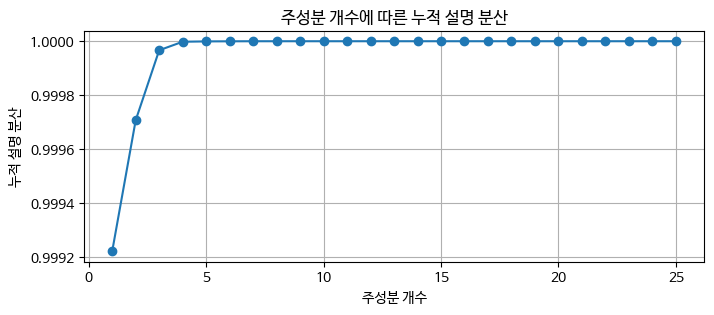

In [ ]:
plt.figure(figsize=(8,3))
plt.plot(num_components, cumulative_variance, marker='o', linestyle='-')
plt.title('주성분 개수에 따른 누적 설명 분산')
plt.xlabel('주성분 개수')
plt.ylabel('누적 설명 분산')
plt.grid(True)
plt.show()
# 주성분 2개일때 데이터셋 99% 이상 설명

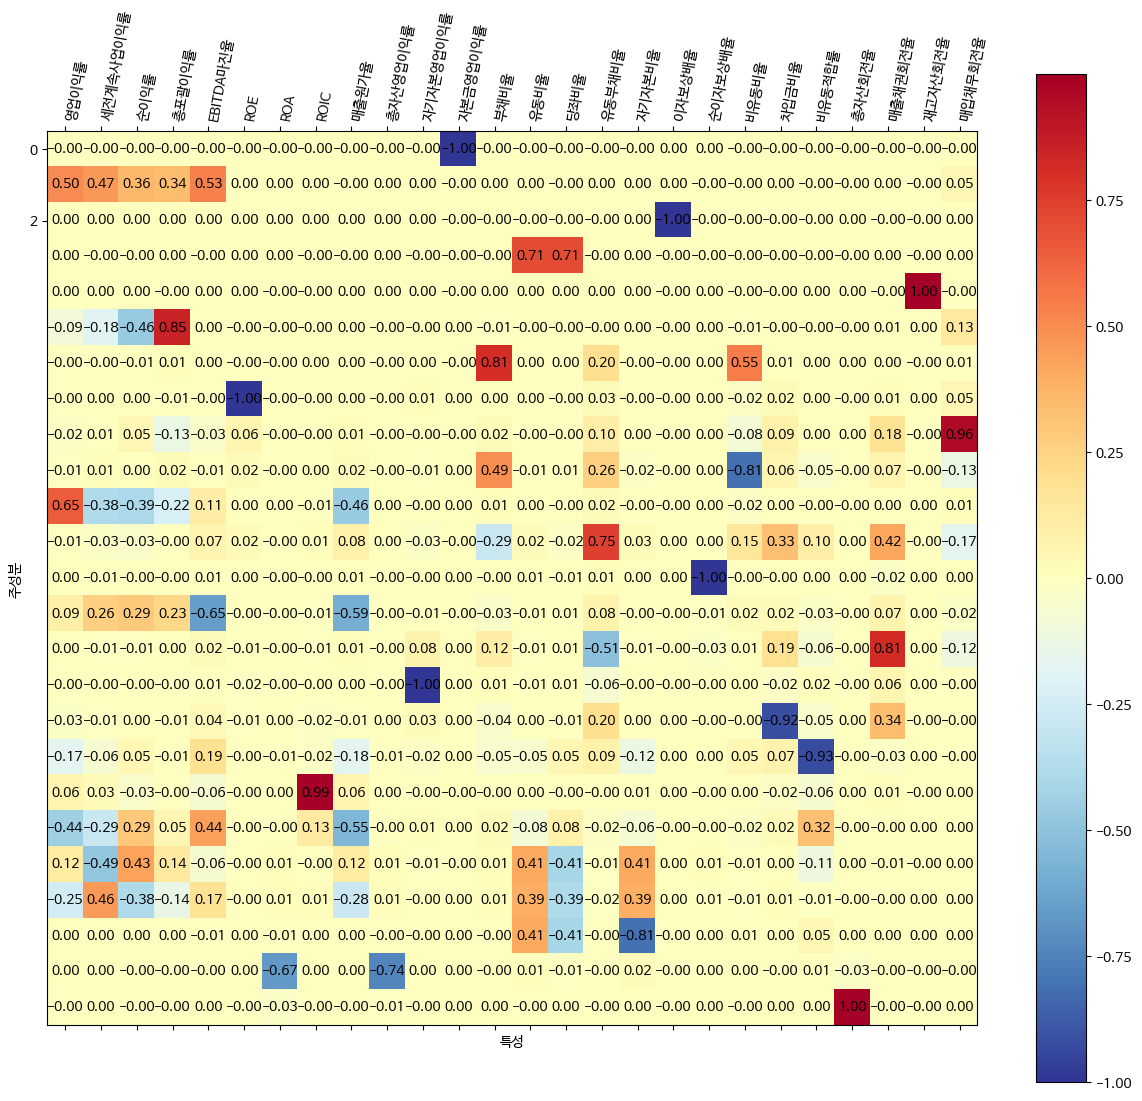

In [ ]:
plt.figure(figsize=(15,13))
plt.matshow(pca.components_, cmap='RdYlBu_r', fignum=1)

plt.yticks([0,2])
plt.colorbar()

plt.xticks(range(len(group[num_cols].columns)), group[num_cols].columns, rotation=80, ha='left')

plt.xlabel('특성')
plt.ylabel('주성분')

for i in range(len(pca.components_)):
    for j in range(len(group[num_cols].columns)):
        text = f'{pca.components_[i, j]:.2f}'
        plt.text(j, i, text, va='center', ha='center', color='black')

## 주성분별 상관성 0.4 이상 변수
# 주성분1: 자본금영업이익률
# 주성분2: 영업이익률, 세전계속사업이익률, 순이익률, 총포괄이익률, EBITDA마진율

In [ ]:
group2 = result.groupby(['Code', 'Name'], as_index=False).mean()
# 'Code' 열의 데이터 형식 확인하여 'Nation' 열 추가
group2['Nation'] = group2['Code'].apply(lambda x: 'KOR' if str(x).isdigit() else 'USA')
# 'Cluster' 열을 문자열로 변환 및 '.0' 제거
group2['Cluster'] = group2['Cluster'].astype(str).str.replace('.0', '')

# 'Cluster' 열을 기준으로 그룹화하여 'Name' 목록 확인
name_clust = group2.groupby('Cluster')['Name'].apply(list)


In [80]:
for cluster, names in name_clust.items():
    print(f'Cluster {cluster}: {names}\n\n')

Cluster 1: ['KR모터스', '경방', '하이트진로', 'CJ대한통운', '하이트진로홀딩스', '두산', 'DL', '일동홀딩스', '기아', '대유플러스', '대원강업', '대동', '삼일제약', '동아쏘시오홀딩스', 'LS네트웍스', '이화산업', '보해양조', '전방', 'DB하이텍', '페이퍼코리아', 'CJ', 'JW중외제약', '대한방직', 'LX인터내셔널', '국보', '금호전기', '동국홀딩스', 'GS글로벌', '남광토건', '백광산업', 'SG글로벌', 'KG케미칼', '대한전선', 'BYC', 'DI동일', '조비', '금양', '케이비아이동국실업', '대상', 'SK네트웍스', '알루코', '대한제당', 'DL건설', '코오롱', '고려산업', '한일철강', '한진', '넥센타이어', '범양건영', '세기상사', '삼익악기', 'TCC스틸', '진흥기업', 'SUN&L', '대유에이텍', 'TYM', '금호건설', '혜인', '코오롱글로벌', '삼양식품', '흥아해운', '쌍용C&E', '한진중공업홀딩스', '대한항공', 'KG모빌리티', '한성기업', '삼영', '사조대림', '현대제철', '한국석유', '태양금속', '동방', '한솔홀딩스', '신세계', '남성', '삼익THK', '서울식품', '송원산업', '깨끗한나라', '삼천리', '한솔테크닉스', '효성', '티웨이홀딩스', '조광페인트', '성신양회', '부산주공', '코스모신소재', 'SGC에너지', '한창', '국동', '모나미', '현대차', '신성통상', '코스모화학', 'SPC삼립', '크라운해태홀딩스', '휴니드', '이수화학', '동부건설', '동원산업', '화승인더', '사조오양', '삼아알미늄', 'SK디스커버리', 'LS', '대원전선', 'GS건설', '대구백화점', '카프로', '대림통상', 'AK홀딩스', 'GS리테일', '사조산업', '한국특강', '일양약품', '이수페타시스', '서연', '태평양물산', '사조동아원', '이건산업', 'NI

## 3. 강화학습 기반 효율적 투자선 시각화

In [53]:
df = result[result['Cluster']==8]
tickers = list(df['Code'].unique())
# 숫자와 문자 티커를 담을 리스트 초기화
korea = []
usa = []

# 티커를 검사하여 적절한 리스트에 추가
for ticker in tickers:
    if ticker.isdigit():
        korea.append(ticker)
    else:
        usa.append(ticker)

# 결과 출력
print("korea:", korea)
print("usa:", usa)

korea: ['000020', '002460', '002810', '002840', '002920', '002960', '003000', '003080', '003120', '003650', '003670', '005180', '005680', '006890', '007700', '008500', '010620', '013000', '016090', '021820', '023000', '024070', '025540', '026940', '026960', '030190', '031440', '033780', '033920', '034300', '035250', '035720', '036570', '039570', '042700', '051600', '052690', '053690', '057050', '058850', '058860', '064960', '075180', '078520', '083420', '092790', '100840', '104700', '107590', '114090', '120030', '122900', '134380', '137310', '192400', '214320']
usa: ['MNST', 'ODFL', 'CHT', 'BNTX', 'LOGI', 'EXEL', 'DSGX', 'CPRI', 'COHR', 'BCPC', 'JJSF', 'KLIC', 'KFY']


In [54]:
data = yf.download(usa, start='2023-09-01')
data.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
data = data.droplevel(0,axis=1)
rets = data.pct_change().fillna(0)

[*********************100%%**********************]  13 of 13 completed


In [55]:
df = rets
df_stocks = pd.DataFrame()
cols = list(df.columns)

for i in cols:
  a = pd.DataFrame(df[i].values, index = df.index, columns = ['등락률'])
  b = pd.DataFrame([i]*len(df.index), index = df.index, columns=['종목'])
  c = pd.concat([a,b], axis=1)
  df_stocks = pd.concat([df_stocks, c], axis = 0)
df_stocks

,등락률,종목
Date,,
2023-09-01,0.000000,BCPC
2023-09-05,-0.046874,BCPC
2023-09-06,-0.009925,BCPC
2023-09-07,-0.003317,BCPC
2023-09-08,-0.004537,BCPC
...,...,...
2023-10-09,0.021165,ODFL
2023-10-10,0.006964,ODFL
2023-10-11,0.001529,ODFL


In [56]:
# 각 종목별 데이터를 저장할 빈 딕셔너리 생성
data_dict = {}

# 각 종목별로 데이터를 가져와 딕셔너리에 저장
for ticker in korea:
    data_dict[ticker] = stock.get_market_ohlcv_by_date("20230901", "20231015", ticker)

In [57]:
results = {}
for ticker, df in data_dict.items():
  results[ticker] = data_dict[ticker]['등락률']
results

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'000020': 날짜
 2023-09-01   -0.200200
 2023-09-04   -1.303912
 2023-09-05    1.524390
 2023-09-06   -0.600601
 2023-09-07    0.805639
 2023-09-08    2.097902
 2023-09-11    1.174168
 2023-09-12   -0.870406
 2023-09-13   -0.878049
 2023-09-14    1.870079
 2023-09-15   -0.386473
 2023-09-18   -1.260912
 2023-09-19   -0.491159
 2023-09-20   -1.382034
 2023-09-21   -1.901902
 2023-09-22   -0.714286
 2023-09-25   -1.130524
 2023-09-26   -0.415800
 2023-09-27    2.296451
 2023-10-04   -1.734694
 2023-10-05    1.038422
 2023-10-06    3.391572
 2023-10-10   -0.099404
 2023-10-11    0.199005
 2023-10-12   -0.198610
 2023-10-13   -0.298507
 Name: 등락률, dtype: float64,
 '002460': 날짜
 2023-09-01    0.000000
 2023-09-04    4.238921
 2023-09-05   -1.293900
 2023-09-06   -2.621723
 2023-09-07   -0.769231
 2023-09-08    0.581395
 2023-09-11    0.770713
 2023-09-12   -0.286807
 2023-09-13    0.575264
 2023-09-14   -0.285987
 2023-09-15    0.669216
 2023-09-18    0.189934
 2023-09-19    0.189573
 2023-09

In [58]:
df_stocks2 = pd.DataFrame()
cols = list(df.columns)

for i in cols:
  a = pd.DataFrame(df[i].values, index = df.index, columns = ['등락률'])
  b = pd.DataFrame([i]*len(df.index), index = df.index, columns=['종목'])
  c = pd.concat([a,b], axis=1)
  df_stocks2 = pd.concat([df_stocks2, c], axis = 0)
df_stocks2

,등락률,종목
날짜,,
2023-09-01,40400.000000,시가
2023-09-04,41000.000000,시가
2023-09-05,40700.000000,시가
2023-09-06,41000.000000,시가
2023-09-07,41150.000000,시가
...,...,...
2023-10-06,-1.138952,등락률
2023-10-10,2.304147,등락률
2023-10-11,0.225225,등락률


In [59]:
df = pd.DataFrame(results)
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,000020,002460,002810,002840,002920,002960,003000,003080,003120,003650,...,100840,104700,107590,114090,120030,122900,134380,137310,192400,214320
날짜,,,,,,,,,,,,,,,,,,,,,
2023-09-01,-0.200200,0.000000,0.078431,-1.445783,-0.328407,0.220751,-0.888889,-1.502504,0.907029,0.282486,...,2.320186,1.854975,-0.221239,0.618429,-1.178782,0.324324,-0.136612,-2.877698,-0.934579,0.861009
2023-09-04,-1.303912,4.238921,-0.078370,-0.794621,-1.317957,0.440529,0.000000,-1.016949,-0.224719,0.140845,...,-0.680272,0.165563,-0.332594,1.536570,1.292247,-0.754310,0.136799,6.090535,-5.424528,-0.121951
2023-09-05,1.524390,-1.293900,-1.803922,0.184843,-1.168614,0.438596,0.000000,0.513699,-1.576577,-0.281294,...,-2.968037,-1.818182,0.000000,0.484262,-0.294406,-1.085776,0.546448,0.000000,-0.249377,0.366300
2023-09-06,-0.600601,-2.621723,-1.916933,-0.984010,0.675676,1.528384,2.690583,-0.340716,-2.288330,0.141044,...,0.705882,-1.178451,-0.556174,3.493976,0.000000,-0.548847,-1.630435,0.387898,-2.150000,0.000000
2023-09-07,0.805639,-0.769231,-1.058632,-0.621118,-1.006711,0.000000,-2.328967,-2.393162,0.702576,0.563380,...,0.000000,-0.511073,-0.782998,-0.698487,-1.279528,-0.662252,-0.138122,-4.636785,-5.212059,-0.243309
2023-09-08,2.097902,0.581395,1.316872,0.312500,-0.338983,-0.215054,2.682563,7.355517,0.697674,-0.420168,...,0.000000,2.054795,0.000000,2.813599,-0.099701,0.111111,-2.904564,3.646677,5.121294,5.121951
2023-09-11,1.174168,0.770713,0.000000,0.373832,1.870748,-0.215517,1.741655,-1.794454,0.000000,0.000000,...,0.934579,0.838926,-0.225479,0.855188,1.097804,0.332963,0.000000,2.971071,-2.512821,-1.856148
2023-09-12,-0.870406,-0.286807,0.649878,-0.124146,-2.671119,-0.215983,-0.570613,0.996678,-1.154734,-0.281294,...,-0.462963,-1.164725,-0.451977,-3.335218,-0.987167,0.331858,0.569801,-3.492787,-1.367701,0.709220
2023-09-13,-0.878049,0.575264,0.564972,-0.435053,0.857633,0.432900,-2.869440,-1.315789,-0.934579,0.282087,...,0.000000,0.000000,-4.653802,0.175439,-0.299103,-0.330761,-1.274788,-0.708104,-0.480000,1.056338


In [60]:
df_stocks2 = pd.DataFrame()
cols = list(df.columns)

for i in cols:
  a = pd.DataFrame(df[i].values, index = df.index, columns = ['등락률'])
  b = pd.DataFrame([i]*len(df.index), index = df.index, columns=['종목'])
  c = pd.concat([a,b], axis=1)
  df_stocks2 = pd.concat([df_stocks2, c], axis = 0)
df_stocks2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,등락률,종목
날짜,,
2023-09-01,-0.200200,000020
2023-09-04,-1.303912,000020
2023-09-05,1.524390,000020
2023-09-06,-0.600601,000020
2023-09-07,0.805639,000020
...,...,...
2023-10-06,-1.138952,214320
2023-10-10,2.304147,214320
2023-10-11,0.225225,214320


In [61]:
df_total = pd.concat([df_stocks, df_stocks2], axis=0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [62]:
df_total.rename(columns={'종목':'티커'}, inplace=True)
df_total

,등락률,티커
2023-09-01,0.000000,BCPC
2023-09-05,-0.046874,BCPC
2023-09-06,-0.009925,BCPC
2023-09-07,-0.003317,BCPC
2023-09-08,-0.004537,BCPC
...,...,...
2023-10-06,-1.138952,214320
2023-10-10,2.304147,214320
2023-10-11,0.225225,214320
2023-10-12,0.337079,214320


In [63]:
df_stocks = df_total
df = df_stocks
df

,등락률,티커
2023-09-01,0.000000,BCPC
2023-09-05,-0.046874,BCPC
2023-09-06,-0.009925,BCPC
2023-09-07,-0.003317,BCPC
2023-09-08,-0.004537,BCPC
...,...,...
2023-10-06,-1.138952,214320
2023-10-10,2.304147,214320
2023-10-11,0.225225,214320
2023-10-12,0.337079,214320


In [64]:
df = df.reset_index(drop=True)

In [65]:
df.loc[0, '등락률']

0.0

In [66]:
import gym
import numpy as np
import pandas as pd
import optuna
from stable_baselines3 import DDPG
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv

# 1. StockTradingEnv: 주식 트레이딩 환경 정의
class StockTradingEnv(gym.Env):
    def __init__(self, df):
        super(StockTradingEnv, self).__init__()

        self.df = df
        self.current_step = 0
        self.portfolio_return_history = []

        # Action space: Proportions for each stock (Continuous action space)
        self.action_space = spaces.Box(low=0, high=1, shape=(len(df['티커'].unique()),))

        # State space: '등락률' for each stock
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(len(df['티커'].unique()),))

    def reset(self):
        self.current_step = 0
        #print("Resetting environment. Initial state:", self._next_observation())
        self.portfolio_return_history = []
        self.df.reset_index(drop=True, inplace=True)

        return self._next_observation()

    def _next_observation(self):

      obs = self.df.loc[self.current_step, '등락률']
      # If obs is not a Series (i.e., it's a scalar), make it into an array
      if not isinstance(obs, pd.Series):
          obs = np.array([obs])
      else:
          obs = obs.values
      return obs


    def step(self, action):
        # Ensure actions sum to 1 to represent allocation of capital between stocks
        action = action / np.sum(action)

        # Get the stock returns for the next day
        next_day_returns = self.df.loc[self.current_step, '등락률']

        # Calculate the portfolio return
        portfolio_return = np.dot(action, next_day_returns)
        self.portfolio_return_history.append(portfolio_return)

        # Calculate the reward using the Sharpe Ratio
        expected_return = np.mean(self.portfolio_return_history)
        risk_free_rate = 0.01  # for example, a 1% risk-free rate
        std_return = np.std(self.portfolio_return_history)
        if std_return == 0:  # to avoid division by zero
            sharpe_ratio = 0
        else:
            sharpe_ratio = (expected_return - risk_free_rate) / std_return

        reward = sharpe_ratio

        # Move to the next day
        self.current_step += 1

        # Get the new observation
        obs = self._next_observation()

        # Check if we're done
        done = self.current_step >= len(self.df) - 1

        return obs, reward, done, {}

# 주식 데이터(df)는 이전과 동일하게 정의합니다.

# 2. objective: optuna의 목표함수 정의
def objective(trial):
    gamma = trial.suggest_float('gamma', 0.9, 0.9999)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])

    env = DummyVecEnv([lambda: StockTradingEnv(df)])  # df는 주식 데이터의 데이터프레임입니다.
    model = DDPG('MlpPolicy', env, gamma=gamma, learning_rate=learning_rate, verbose=1, tensorboard_log="./tensorboard_logs")
    model.learn(total_timesteps=20000)

    rewards = []
    obs = env.reset()
    for _ in range(5):  # 예: 5일 동안의 트레이딩을 시뮬레이션합니다.
        action, _ = model.predict(obs)
        obs, reward, done, _ = env.step(action)
        rewards.append(reward)

    # 5일 동안의 보상의 평균을 반환합니다.
    avg_reward = np.mean(rewards)
    return avg_reward

# optuna를 사용하여 하이퍼파라미터 튜닝을 시작합니다.
study = optuna.create_study(direction="maximize")  # 보상을 최대화합니다.
study.optimize(objective, n_trials=3)  # 예: 30번의 시도로 최적의 하이퍼파라미터를 찾습니다.

# 최적의 하이퍼파라미터를 출력합니다.
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2023-10-15 22:36:48,364] A new study created in memory with name: no-name-c7a50343-8d9f-4bb6-810c-bc19a3b82574
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cuda device
Logging to ./tensorboard_logs/DDPG_1
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 157       |
|    time_elapsed    | 46        |
|    total_timesteps | 7380      |
| train/             |           |
|    actor_loss      | -1.24e+05 |
|    critic_loss     | 1.7e+09   |
|    learning_rate   | 0.000157  |
|    n_updates       | 5535      |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 146       |
|    time_elapsed    | 100       |
|    total_timesteps | 14760     |
| train/             |           |
|    actor_loss      | -1.64e+06 |
|    critic_loss     | 1.25e+11  |
|    learning_rate   | 0.000157  |
|    n_updates       | 12915     |
----------------------------------


[I 2023-10-15 22:39:26,316] Trial 0 finished with value: -17.53148078918457 and parameters: {'gamma': 0.9234246059183253, 'learning_rate': 0.00015730031264883122, 'batch_size': 32}. Best is trial 0 with value: -17.53148078918457.


Using cuda device
Logging to ./tensorboard_logs/DDPG_2
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 170       |
|    time_elapsed    | 43        |
|    total_timesteps | 7380      |
| train/             |           |
|    actor_loss      | -1.97e+04 |
|    critic_loss     | 3.32e+07  |
|    learning_rate   | 0.000142  |
|    n_updates       | 5535      |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 151       |
|    time_elapsed    | 97        |
|    total_timesteps | 14760     |
| train/             |           |
|    actor_loss      | -1.16e+06 |
|    critic_loss     | 7.93e+10  |
|    learning_rate   | 0.000142  |
|    n_updates       | 12915     |
----------------------------------


[I 2023-10-15 22:41:55,493] Trial 1 finished with value: -15.924159049987793 and parameters: {'gamma': 0.9481106991413353, 'learning_rate': 0.00014159635194873685, 'batch_size': 256}. Best is trial 1 with value: -15.924159049987793.


Using cuda device
Logging to ./tensorboard_logs/DDPG_3
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 168       |
|    time_elapsed    | 43        |
|    total_timesteps | 7380      |
| train/             |           |
|    actor_loss      | -2.24e+04 |
|    critic_loss     | 8.31e+05  |
|    learning_rate   | 0.00168   |
|    n_updates       | 5535      |
----------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 151      |
|    time_elapsed    | 97       |
|    total_timesteps | 14760    |
| train/             |          |
|    actor_loss      | -2.7e+03 |
|    critic_loss     | 3.96e+04 |
|    learning_rate   | 0.00168  |
|    n_updates       | 12915    |
---------------------------------


[I 2023-10-15 22:44:23,731] Trial 2 finished with value: -16.893436431884766 and parameters: {'gamma': 0.9448464318704534, 'learning_rate': 0.0016825925560261486, 'batch_size': 128}. Best is trial 1 with value: -15.924159049987793.


Number of finished trials:  3
Best trial:
  Value:  -15.924159049987793
  Params: 
    gamma: 0.9481106991413353
    learning_rate: 0.00014159635194873685
    batch_size: 256


In [67]:
from stable_baselines3.common.callbacks import BaseCallback

class PrintRewardCallback(BaseCallback):
    def __init__(self, check_freq: int, verbose=0):
        super(PrintRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.rewards = []

    def _on_step(self):
        # Check if ep_info_buffer is not empty
        if self.model.ep_info_buffer:
            self.rewards.append(self.model.ep_info_buffer[-1]['r'])  # Append the reward

        if self.n_calls % self.check_freq == 0 and self.rewards:
            mean_reward = np.mean(self.rewards[-self.check_freq:])
            print(f"Mean Reward: {mean_reward:.2f}")
        return True


In [68]:
best_params = study.best_params

env = DummyVecEnv([lambda: StockTradingEnv(df_stocks)])
model = DDPG('MlpPolicy', env,
             gamma=best_params["gamma"],
             learning_rate=best_params["learning_rate"],
             batch_size=best_params["batch_size"],
             verbose=1,
             tensorboard_log="./tensorboard_logs")

callback = PrintRewardCallback(check_freq=1000)
model.learn(total_timesteps=20000)

Using cuda device
Logging to ./tensorboard_logs/DDPG_4
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 167       |
|    time_elapsed    | 43        |
|    total_timesteps | 7380      |
| train/             |           |
|    actor_loss      | -5.21e+04 |
|    critic_loss     | 3.74e+08  |
|    learning_rate   | 0.000142  |
|    n_updates       | 5535      |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 149       |
|    time_elapsed    | 98        |
|    total_timesteps | 14760     |
| train/             |           |
|    actor_loss      | -3.23e+05 |
|    critic_loss     | 5.69e+09  |
|    learning_rate   | 0.000142  |
|    n_updates       | 12915     |
----------------------------------


In [69]:
obs = env.reset()
for _ in range(len(df_stocks)):
    action, _ = model.predict(obs)
    obs, reward, done, _ = env.step(action)

action

array([[1.        , 0.        , 0.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        0.        , 1.        , 0.        , 0.        , 1.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 1.        ,
        1.        , 0.        , 1.        , 0.        , 1.        ,
        1.        , 0.        , 0.99999595, 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        1.        , 1.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        1.        , 1.        , 0.        , 0.        , 0.        ,
        1.        , 1.        , 0.        , 1.        , 1.        ,
        0.        , 1.        , 0.        , 1.        , 1.        ,
        1.        , 0.        , 0.        , 0.        ]], dtype=float32)

In [70]:
model.save("ddpgV8") # 클러스터 번호 매칭
#model = DDPG.load("path_to_save_model")

In [71]:
lst = list(df['티커'].unique())
tickers = [val for i, val in enumerate(lst) if action[0][i] == 1] # 매수시그널=1만 필터링

In [82]:
korea = []
usa = []

# 티커를 검사하여 적절한 리스트에 추가
for ticker in tickers:
    if ticker.isdigit():
        korea.append(ticker)
    else:
        usa.append(ticker)
print("korea:", korea)
print("usa:", usa)


korea: ['002460', '002840', '003650', '005180', '005680', '007700', '010620', '013000', '026960', '033780', '033920', '034300', '042700', '053690', '057050', '075180', '078520', '092790', '100840', '107590', '120030', '122900', '134380']
usa: ['BCPC', 'COHR', 'CPRI', 'DSGX', 'EXEL', 'JJSF', 'KFY', 'KLIC', 'MNST']


## 5. 클러스터 샤프지수 포트폴리오 제시

In [83]:
# 한국
# 특정 경고 메시지 유형을 무시하거나 숨기기
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Filter the data to include only rows with 'Nation' equal to 'KOR' and 'Cluster' equal to 1
filtered_data8_kor = group2[(group2['Nation'] == 'KOR') & (group2['Cluster'] == '8')] ###수정###

# Ticker symbols to analyze (Korean stocks) 클러스터1번 한국 종목 심볼 리스트.
krx_symbols = korea

# Benchmark symbol for calculating beta (KOSPI 200)
benchmark_symbol = '069500'

# Initialize dataframe to store fetched data
df = pd.DataFrame()

period = '3mo'
# Fetch data and calculate daily returns for Korean stocks
for symbol in krx_symbols+[benchmark_symbol]:
    df_temp = stock.get_market_ohlcv_by_date('20230901', '20231015', ticker=symbol)
    df_temp['Return'] = df_temp['종가'].pct_change().fillna(0)
    df_temp['Symbol'] = symbol
    df_temp['Period'] = period
    df = df.append(df_temp)

benchmark_returns = df[df['Symbol'] == benchmark_symbol]['Return']

# Initialize lists to store Beta correlation, Return, Sharpe ratio, and Volatility for each stock
beta_correlations = []
returns = []
sharpe_ratios = []
volatilities = []

risk_free_rate = 0.02
# Calculate Beta correlation, Return, Sharpe ratio, and Volatility for each Korean stock
for symbol in krx_symbols:
    krx_stock_returns = df[(df['Symbol'] == symbol) & (df['Period'] == period)]['Return']

    # Exclude NaN values from returns
    krx_stock_returns = krx_stock_returns[~np.isnan(krx_stock_returns)]

    # Check if there are valid returns to calculate metrics
    if len(krx_stock_returns) > 0:
        # Calculate beta using covariance and variance
        cov_matrix = krx_stock_returns.cov(benchmark_returns)
        benchmark_var = benchmark_returns.var()
        beta = cov_matrix / benchmark_var
        beta_correlations.append(beta)

        # Calculate average return
        avg_return = np.mean(krx_stock_returns)
        returns.append(avg_return)

        # Calculate Sharpe ratio
        sharpe_ratio = (avg_return - risk_free_rate) / np.std(krx_stock_returns)
        sharpe_ratios.append(sharpe_ratio)

        # Calculate volatility
        volatility = np.std(krx_stock_returns)
        volatilities.append(volatility)

# Create dictionaries to store the calculated metrics
beta_data = {symbol: beta for symbol, beta in zip(krx_symbols, beta_correlations)}
return_data = {symbol: ret for symbol, ret in zip(krx_symbols, returns)}
sharpe_data = {symbol: ratio for symbol, ratio in zip(krx_symbols, sharpe_ratios)}
volatility_data = {symbol: vol for symbol, vol in zip(krx_symbols, volatilities)}

# Add the calculated metrics to 'filtered_data8_kor' DataFrame
# filtered_data8_kor['Beta correlation'] = filtered_data8_kor['Code'].map(beta_data)
filtered_data8_kor['Return'] = filtered_data8_kor['Code'].map(return_data)
filtered_data8_kor['Sharpe ratio'] = filtered_data8_kor['Code'].map(sharpe_data)
filtered_data8_kor['Volatility'] = filtered_data8_kor['Code'].map(volatility_data)

# Display the updated 'filtered_data8_kor' DataFrame
filtered_data8_kor

<ipython-input-83-7a3ad84ea7e8>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data8_kor['Return'] = filtered_data8_kor['Code'].map(return_data)
<ipython-input-83-7a3ad84ea7e8>:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data8_kor['Sharpe ratio'] = filtered_data8_kor['Code'].map(sharpe_data)
<ipython-input-83-7a3ad84ea7e8>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

,Code,Name,영업이익률,세전계속사업이익률,순이익률,총포괄이익률,EBITDA마진율,ROE,ROA,ROIC,...,비유동적합률,총자산회전율,매출채권회전율,재고자산회전율,매입채무회전율,Cluster,Nation,Return,Sharpe ratio,Volatility
0,000020,동화약품,5.109259,7.727778,5.886481,5.660000,12.405185,1.416667,1.075556,1.507407,...,66.574630,0.179631,1.128715,1.808073,2.847574,8,KOR,NaN,NaN,NaN
109,002460,화성산업,3.461111,3.372778,2.522778,3.236852,4.227222,0.857593,0.550556,2.570370,...,51.446296,0.196486,3601.096103,1.505044,2.722271,8,KOR,0.000027,-1.200843,0.016633
120,002810,삼영무역,3.195926,10.883333,9.065000,8.644444,11.017407,2.345000,1.905000,2.092593,...,51.624630,0.222398,1.052646,4.297754,2.484854,8,KOR,NaN,NaN,NaN
122,002840,미원상사,10.750556,13.307222,10.953148,10.688333,18.915926,3.960926,2.869630,3.169815,...,69.335741,0.255203,1.481480,1.308216,3.906851,8,KOR,-0.000059,-1.566097,0.012808
126,002920,유성기업,1.951481,5.865370,4.725000,4.569815,10.864630,1.350556,0.963333,0.189815,...,63.496296,0.196927,1.372187,2.049551,2.536917,8,KOR,NaN,NaN,NaN
127,002960,한국쉘석유,14.172778,14.965185,11.222407,10.374074,15.486296,8.082407,5.339074,16.993148,...,23.050741,0.477407,1.918101,2.314037,4.543278,8,KOR,NaN,NaN,NaN
129,003000,부광약품,9.387963,13.813519,9.491852,7.984815,17.446852,1.961296,1.649444,1.763333,...,46.555185,0.134346,0.604711,1.063656,6.840557,8,KOR,NaN,NaN,NaN
134,003080,성보화학,-69.668333,-33.146111,-28.134259,-22.077778,-23.206667,1.680556,1.330000,2.785370,...,53.987963,0.095852,0.790441,0.496669,1.909817,8,KOR,NaN,NaN,NaN
136,003120,일성신약,1.114630,52.759074,39.259259,13.273333,43.032407,1.711852,1.490926,-0.307407,...,47.871667,0.039724,0.777820,0.851428,6.123856,8,KOR,NaN,NaN,NaN
159,003650,미창석유,6.735926,8.476667,6.459630,5.886296,8.865926,2.653889,2.170000,3.275000,...,30.181852,0.347502,1.454998,1.624042,3.600538,8,KOR,0.000768,-1.610013,0.011945


In [89]:
# 미국
filtered_data8_usa = group2[(group2['Nation'] == 'USA') & (group2['Cluster'] == '8')]

# Ticker symbols to analyze (USA stocks)
usa_symbols = usa

# Benchmark symbol for calculating beta
benchmark_symbol = ['SPY', 'QQQ']

# Initialize dataframe to store fetched data
df = pd.DataFrame()

# Fetch data and calculate daily returns for US stocks and benchmarks
for symbol in usa_symbols:
    data = yf.download(symbol, start='2023-09-01', end='2023-10-15')
    data['Return'] = data['Close'].pct_change().fillna(0)
    data['Symbol'] = symbol
    data['Period'] = 'Daily'
    df = df.append(data)

# Beta Correlation, Return, Sharpe ratio, 및 Volatility를 저장할 리스트를 초기화합니다.
beta_correlations = []
returns = []
sharpe_ratios = []
volatilities = []

# 개별 종목에 대한 Beta Correlation, Return, Sharpe ratio, 및 Volatility를 계산합니다.
risk_free_rate = 0.02  # 예시로 설정
for symbol in usa_symbols:
    stock_returns = df[(df['Symbol'] == symbol) & (df['Period'] == 'Daily')]['Return']

    # NaN 값을 제외합니다.
    stock_returns = stock_returns[~np.isnan(stock_returns)]

    # 계산 가능한 메트릭이 있는지 확인합니다.
    if len(stock_returns) > 0:
        # Beta를 Covariance 및 Variance를 사용하여 계산합니다.
        benchmark_symbol_returns = df[(df['Symbol'].isin(benchmark_symbol)) & (df['Period'] == 'Daily')]['Return']
        cov_matrix = stock_returns.cov(benchmark_symbol_returns)
        benchmark_var = benchmark_symbol_returns.var()
        beta = cov_matrix / benchmark_var
        beta_correlations.append(beta)  # Beta Correlation을 리스트에 추가

        # 평균 Return을 계산합니다.
        avg_return = np.mean(stock_returns)
        returns.append(avg_return)

        # Sharpe ratio를 계산합니다.
        sharpe_ratio = (avg_return - risk_free_rate) / np.std(stock_returns)
        sharpe_ratios.append(sharpe_ratio)

        # Volatility를 계산합니다.
        volatility = np.std(stock_returns)
        volatilities.append(volatility)

# 각 메트릭을 DataFrames에 추가합니다.
# filtered_data8_usa['Beta correlation'] = beta_correlations  # Beta Correlation 컬럼을 추가
filtered_data8_usa['Return'] = returns
filtered_data8_usa['Sharpe ratio'] = sharpe_ratios
filtered_data8_usa['Volatility'] = volatilities

# 결과를 표시합니다.
filtered_data8_usa

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ValueError: ignored

In [90]:
# 미국+한국 결합
# Combine 'korean_stock_df' and 'us_stock_df' with 'result' based on 'Code'
filtered_data8 = pd.concat([filtered_data8_kor, filtered_data8_usa], ignore_index=True)  ###수정###

filtered_data8

,Code,Name,영업이익률,세전계속사업이익률,순이익률,총포괄이익률,EBITDA마진율,ROE,ROA,ROIC,...,비유동적합률,총자산회전율,매출채권회전율,재고자산회전율,매입채무회전율,Cluster,Nation,Return,Sharpe ratio,Volatility
0,000020,동화약품,5.109259,7.727778,5.886481,5.660000,12.405185,1.416667,1.075556,1.507407,...,66.574630,0.179631,1.128715,1.808073,2.847574,8,KOR,NaN,NaN,NaN
1,002460,화성산업,3.461111,3.372778,2.522778,3.236852,4.227222,0.857593,0.550556,2.570370,...,51.446296,0.196486,3601.096103,1.505044,2.722271,8,KOR,0.000027,-1.200843,0.016633
2,002810,삼영무역,3.195926,10.883333,9.065000,8.644444,11.017407,2.345000,1.905000,2.092593,...,51.624630,0.222398,1.052646,4.297754,2.484854,8,KOR,NaN,NaN,NaN
3,002840,미원상사,10.750556,13.307222,10.953148,10.688333,18.915926,3.960926,2.869630,3.169815,...,69.335741,0.255203,1.481480,1.308216,3.906851,8,KOR,-0.000059,-1.566097,0.012808
4,002920,유성기업,1.951481,5.865370,4.725000,4.569815,10.864630,1.350556,0.963333,0.189815,...,63.496296,0.196927,1.372187,2.049551,2.536917,8,KOR,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,KFY,Korn Ferry,8.600185,8.662407,6.108519,0.000000,13.604074,2.668889,1.474815,0.000000,...,71.761111,0.237336,1.222142,0.000000,16.100061,8,USA,NaN,NaN,NaN
65,KLIC,Kulicke and Soffa Industries,14.487407,14.941852,12.392037,0.000000,17.382037,4.735370,3.175370,0.000000,...,19.754259,0.207499,1.071954,2.238670,3.354710,8,USA,NaN,NaN,NaN
66,LOGI,Logitech International,7.367222,7.657778,6.454074,0.000000,10.956111,4.371667,2.467593,0.000000,...,50.772778,0.360285,2.003796,2.176443,1.935369,8,USA,NaN,NaN,NaN
67,MNST,Monster Beverage,30.495185,30.508333,21.378148,0.000000,31.049074,7.004259,5.319259,0.000000,...,42.820370,0.267053,1.819402,3.203031,3.970372,8,USA,NaN,NaN,NaN


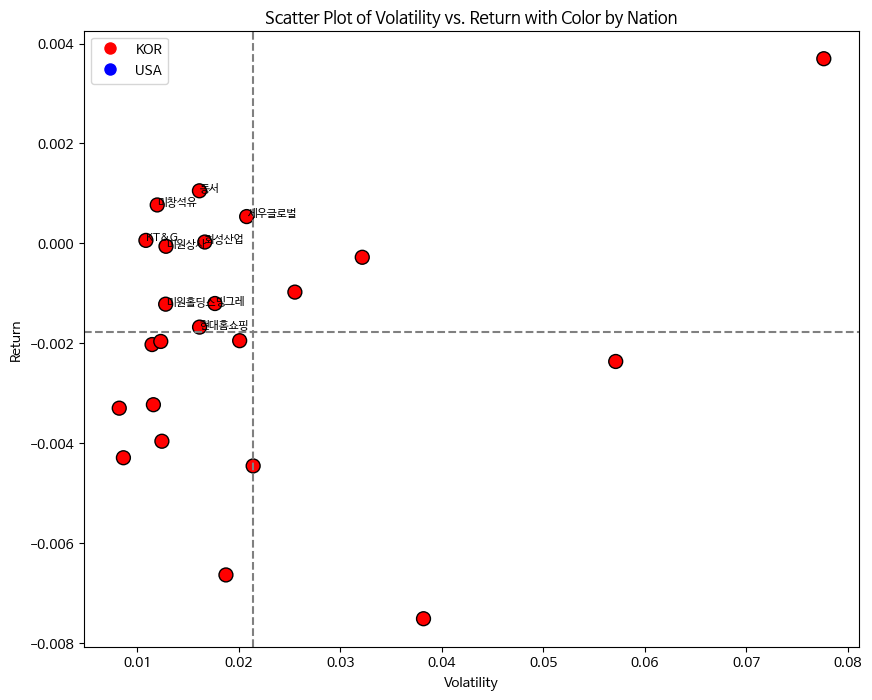

In [91]:
# Map 'Nation' values to colors
filtered_data8['Color'] = np.where(filtered_data8['Nation'] == 'KOR', 'red', 'blue')

# Create a scatter plot using the 'Color' column as colors
plt.figure(figsize=(10,8))
scatter = plt.scatter(filtered_data8['Volatility'], filtered_data8['Return'], c=filtered_data8['Color'], marker='o', edgecolor='k', s=100)

# Add horizontal and vertical average lines
avg_volatility = filtered_data8['Volatility'].mean()
avg_return = filtered_data8['Return'].mean()
plt.axhline(avg_return, color='gray', linestyle='--')
plt.axvline(avg_volatility, color='gray', linestyle='--')

# Add labels for 'Name' only if they are above average
for i, row in filtered_data8.iterrows():
    if row['Return'] > avg_return and row['Volatility'] < avg_volatility:
        plt.annotate(row['Name'], (row['Volatility'], row['Return']), fontsize=8)

# Add labels and title
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Scatter Plot of Volatility vs. Return with Color by Nation')

# Add a custom colorbar legend
custom_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='KOR'),
                plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='USA')]
plt.legend(handles=custom_legend)

# Show the plot
plt.grid(False)
plt.show()